# Gaussian-process optimisation demo

`GpOptimiser` extends the functionality of `GpRegressor` to perform Gaussian-process optimisation, also often referred to as 'Bayesian optimisation'.

Bayesian optimisation is suited to problems for which a single evaluation of the function being explored is expensive, such that the total number 
of function evaluations must be made as small as possible.

First define an objective function whose value will we seek to maximise:

In [1]:
from numpy import sin, cos, linspace, array, meshgrid

# define the function whose maximum we will search for
def objective_function(x):
    return sin(0.5*x) + 3 / (1 + (x-1)**2)

# create some initialisation data
x = array([-8,-7,6,8])
y = objective_function(x)

In Bayesian optimisation, the next point to evaluate is chosen by maximising an 'acquisition function'. Two types of acquisition function are presently available: the 'upper-confidence-bound', implemented as the `UpperConfidenceBound` class, and the 'expected improvement', implemented as the `ExpectedImprovement` class. The acquisition function to be used is set by importing one of these classes from `gp` and passing it to `GpOptimiser` via the `acquisition` keyword argument.

In [2]:
# define bounds for the optimisation
bounds = [(-8,8)]

# create an instance of GpOptimiser
from inference.gp import GpOptimiser, UpperConfidenceBound
GPO = GpOptimiser(x, y, bounds=bounds, acquisition=UpperConfidenceBound)

The location of the next point at which to evaluate the objective function is generated using the `propopse_evaluation()` method. Once the evaluation is complete, the new data can be passed back to `GpOptimiser` via the `add_evaluation()` method. Repeating this process advances the algorithm:

In [3]:
# Store the current state of the system for plotting later
M = 500
x_gp = linspace(*bounds[0],M)
y_func = objective_function(x_gp)
mu, sig = GPO(x_gp)
means = [mu]
sigmas = [sig]
acquis = [array([GPO.acquisition(k) for k in x_gp])]


for i in range(5):
    # request the proposed evaluation
    new_x = GPO.propose_evaluation()

    # evaluate the new point
    new_y = objective_function(new_x)

    # update the gaussian process with the new information
    GPO.add_evaluation(new_x, new_y)

    # Store the current state of the system for plotting later
    mu, sig = GPO(x_gp)
    means.append(mu)
    sigmas.append(sig)
    acquis.append(array([GPO.acquisition(k) for k in x_gp]))

We can now plot the state of the system at each iteration to show how the algorithm progresses:

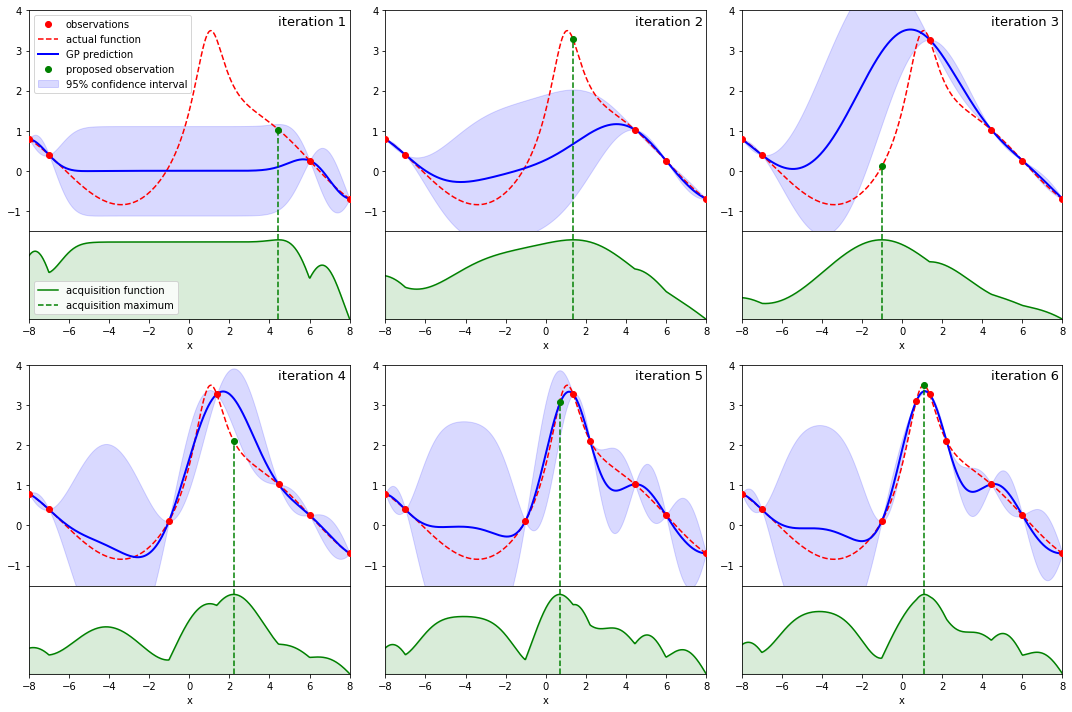

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes = plt.subplots(2, 3, gridspec_kw={'height_ratios': [1,1]}, figsize = (15,10))

for k,i,j in [(i,*divmod(i,3)) for i in range(6)]:
    aq = acquis[k] - acquis[k].min()
    proposal = x_gp[aq.argmax()]
    
    divider = make_axes_locatable(axes[i,j])
    acq_ax = divider.append_axes("bottom", size="40%", pad=0.0)
    
    axes[i,j].plot(GPO.x[:k+4], GPO.y[:k+4], 'o', c = 'red', label = 'observations', zorder = 5)
    axes[i,j].plot(x_gp, y_func, lw = 1.5, c = 'red', ls = 'dashed', label = 'actual function')
    axes[i,j].plot(x_gp, means[k], lw = 2, c = 'blue', label = 'GP prediction')
    axes[i,j].fill_between(x_gp, (means[k]-2*sigmas[k]), y2=(means[k]+2*sigmas[k]), color = 'blue', alpha = 0.15, label = '95% confidence interval')
    axes[i,j].set_ylim([-1.5,4])
    axes[i,j].set_xlim([-8,8])
    axes[i,j].set_xticks([])
    axes[i,j].text(0.99,0.98,'iteration {}'.format(k+1), transform = axes[i,j].transAxes, verticalalignment='top', horizontalalignment='right', fontsize=13)    
    axes[i,j].plot([proposal]*2, [-1.5,objective_function(proposal)], c = 'green', ls = 'dashed')
    axes[i,j].plot(proposal, objective_function(proposal), 'o', c = 'green', label = 'proposed observation')
    
    acq_ax.fill_between(x_gp, 0.9*aq/aq.max(), color = 'green', alpha = 0.15)
    acq_ax.plot(x_gp, 0.9*aq/aq.max(), color = 'green', label = 'acquisition function')
    acq_ax.plot([proposal]*2, [0.,1.], c = 'green', ls = 'dashed', label = 'acquisition maximum')
    acq_ax.set_ylim([0,1])
    acq_ax.set_xlim([-8,8])
    acq_ax.set_yticks([])
    acq_ax.set_xlabel('x')
    
    if k == 0:
        axes[i,j].legend()
        acq_ax.legend()

plt.tight_layout()
plt.show()